In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 50
muse_train_dataset = data.make_dataset('../data/tfrecord/muse_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_valid_dataset = data.make_dataset('../data/tfrecord/muse_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_test_dataset = data.make_dataset('../data/tfrecord/muse_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                 from_script='en',
                                 to_script='cmu',
                                 batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)

In [10]:
importlib.reload(model_one)
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)

encoder_config = model_one.Config(lstm_size=120,
                                  embedding_size=60,
                                  attention_size=None,
                                  vocab_size=script.SCRIPTS['en'].vocab_size)
decoder_config = model_one.Config(lstm_size=80,
                                  embedding_size=60,
                                  attention_size=60,
                                  # attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=80,
                                  embedding_size=60,
                                  attention_size=60,
                                  attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['cmu'].vocab_size)
encoder = model_one.Encoder(encoder_config)
decoder = model_one.Decoder(decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder,
                                 cmu_decoder=cmu_decoder)

In [47]:
importlib.reload(train)
best_val_loss = None
for e in range(1):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=encoder,
                                     decoder=cmu_decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 2.218, Valid Loss 2.313
([['D EH1 R IH0 K IH0 NG', 'D EH1 R IH0 K AH0 CH ER0']], array([[-4.38515372, -6.12553985]]))


In [ ]:
importlib.reload(train)
best_val_loss = None
for e in range(1):
    loss = train.run_one_epoch(train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               train_encoder=False,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=encoder,
                                     decoder=decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

In [19]:
importlib.reload(train)
best_val_loss = None
for e in range(15):
    loss = train.run_one_epoch(eob_train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               train_encoder=True,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(eob_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=encoder,
                                     decoder=decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=encoder,
                               decoder=decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 3.555, Valid Loss 5.109
([['デリック', 'デリックアイクライク']], array([[-2.17633232, -5.87912952]]))


Epoch 1: Train Loss 3.379, Valid Loss 5.067
([['デリック', 'デリックカリック']], array([[-2.60908625, -4.6938364 ]]))


Epoch 2: Train Loss 3.212, Valid Loss 5.169
([['デリック', 'デリックリ']], array([[-2.376946  , -3.27223637]]))


Epoch 3: Train Loss 3.065, Valid Loss 5.059
([['デリック', 'デリックカリック']], array([[-1.63988235, -2.96083623]]))


Epoch 4: Train Loss 2.934, Valid Loss 5.034
([['デリック', 'デリックリ']], array([[-1.28608597, -3.26429863]]))


Epoch 5: Train Loss 2.829, Valid Loss 5.096
([['デリック', 'デリックカリック']], array([[-0.88268069, -2.55607673]]))


Epoch 6: Train Loss 2.698, Valid Loss 5.086
([['デリック', 'デリックカリック']], array([[-1.80448568, -2.62404867]]))


Epoch 7: Train Loss 2.588, Valid Loss 5.163
([['デリック', 'ディック']], array([[-1.29401034, -1.93215085]]))


Epoch 8: Train Loss 2.490, Valid Loss 5.147
([['デリック', 'デリックカリック']], array([[-1.59695258, -2.69464474]]))


Epoch 9: Train Loss 2.397, Valid Loss 5.174
([['デリック', 'ディック']], array([[-1.3000717 , -2.18272001]]))


Epoch 10: Train Loss 2.285, Valid Loss 5.234
([['デリックカリック', 'デリック']], array([[-1.98700093, -2.15848666]]))


Epoch 11: Train Loss 2.197, Valid Loss 5.305
([['デリックカリック', 'デリック']], array([[-1.70180749, -1.87576779]]))


Epoch 12: Train Loss 2.111, Valid Loss 5.361
([['デリックカリック', 'ディックリ']], array([[-2.41139568, -2.74018143]]))


KeyboardInterrupt: 

In [23]:
checkpoint.restore(checkpoint_prefix + '-18').assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=encoder,
                    decoder=decoder,
                    loss_function=loss_function)

<tf.Tensor: id=318139981, shape=(), dtype=float32, numpy=5.080119>

In [24]:
decode.transliterate(input_strs=['william'],
                     from_script='en',
                     to_script='ja',
                     encoder=encoder,
                     decoder=decoder,
                     k_best=2,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

([['ヒリアン', 'ヒリアム']], array([[-2.11734716, -2.50968837]]))

In [12]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [25]:
importlib.reload(decode)
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=encoder,
                     decoder=decoder,
                     k_best=20,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

In [26]:
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.44414019715224534

In [27]:
importlib.reload(evaluate)

ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]

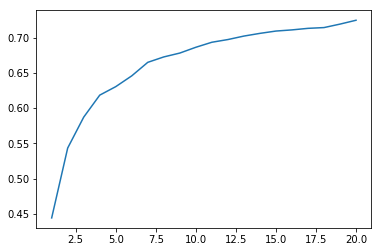

In [28]:
plt.plot(ks, accuracies)

In [29]:
importlib.reload(evaluate)
evaluate.mrr(valid_df['ja'].values,
             tr,
             k=20)

0.5288660969831264